<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Цель:

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders`.

**Используемые библиотеки**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

**Глобальные переменные**

In [2]:
state = np.random.RandomState(12345)

## Подготовка

### Загрузка данных

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


#### Вывод
Данные загружены, Nan-значений не обнаружено, данные отображаются нормально.

### Ресемплирование

Для начала проверим, в хронологическом порядке расположены даты и время, чтобы ресемплирование было корректным

In [6]:
if df.index.is_monotonic:
    print('Данные расположены в хронологическом порядке')
else:
    print('Данные перемешаны')

Данные расположены в хронологическом порядке


Убедившись в монотонности временного ряда, можно перейти к ресемплированию

In [7]:
df = df.resample('1H').sum()

In [8]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


#### Вывод
Ресемплирование проведено успешно! Теперь в num_orders лежат данные про среднее количество заказов в час.

## Анализ

**Скользящее среднее**

In [9]:
df['rolling_mean'] = df.rolling(7).mean()
df = df.dropna()

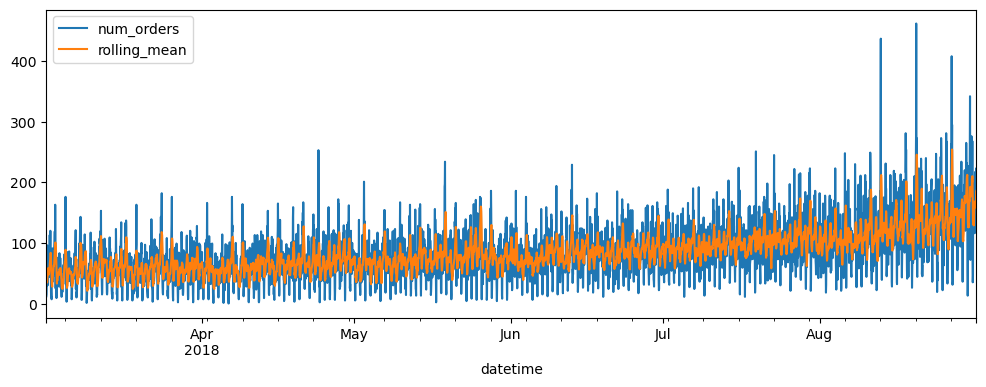

In [10]:
df.plot(figsize=(12, 4));

Как мы видим скользящее среднее показывает тренд увеличения среднего количества заказов такси с начала марта по конец августа. Это довольно логично, ведь именно к осени погода начинает портиться, и люди вместо прогулки выбирают более приспособленный к плохой погоде вид транспорта -- такси.

**Тренд и сезонность**

In [11]:
df = df.drop('rolling_mean', axis=1)

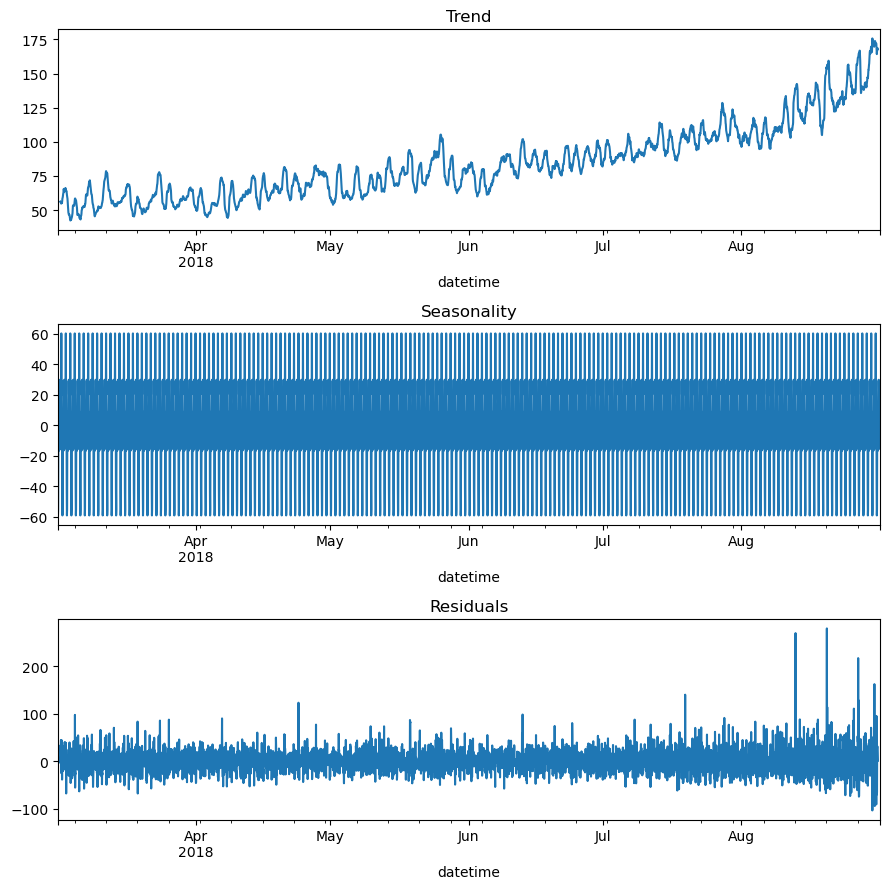

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(9, 9))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Как и предполагалось тренд является положительным, а вот на сезонность надо посмотреть поближе.

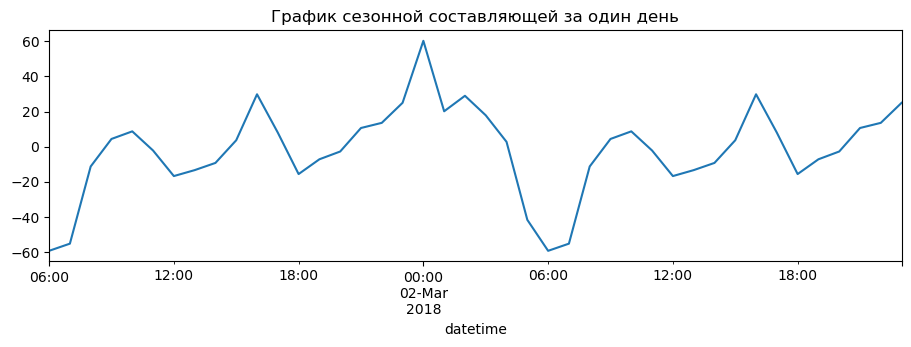

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(figsize=(11, 3))
plt.title('График сезонной составляющей за один день');

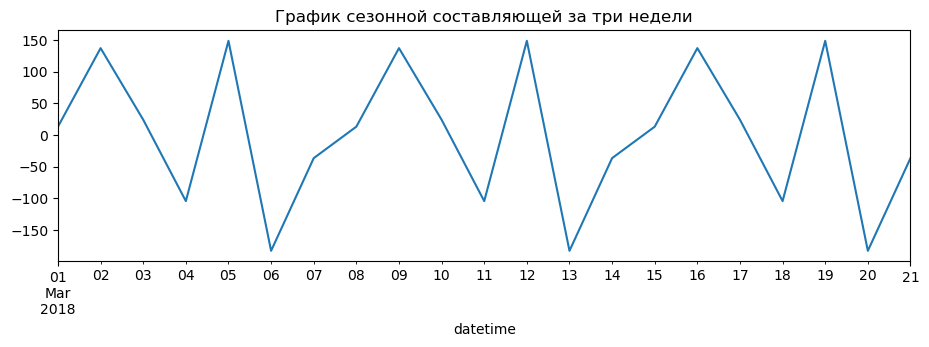

In [15]:
decomposed = seasonal_decompose(df.resample('1D').sum())
decomposed.seasonal['2018-03-01':'2018-03-21'].plot(figsize=(11, 3))
plt.title('График сезонной составляющей за три недели');

Как мы видим пики заказов такси приходятся на `9:00`, `17:00`, `00:00`, `2:00`, минимум заказов -- на раннее утро, примерно 6 утра.

Количество заказов растет с `6:00` до `10:00` -- время, в которое все едут на работу и везут детей в учебные заведения, 

потом с `12:00` до `17:00` -- время обеда и конец учебного дня, 

далее с `18:00` до `00:00` -- окончание рабочего дня и закрытие кафе/ресторанов/баров,

и наконец с `00:00` до `2:00` -- закрытие ночных клубов и тд.

Также наблюдается недельная сезонность, учитывая что 5 марта 2018 года это понедельник, то можно увидеть следующее:

Пики заказов приходятся на понедельник и пятницу, минимум заказов -- на вторник. 

Теперь посмотрим на стационарность временного ряда

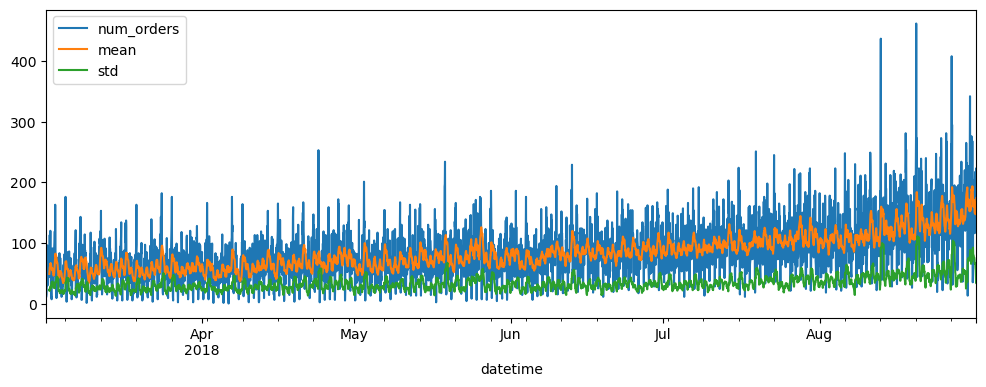

In [16]:
new_df = df.resample('1H').mean()
new_df['mean'] = new_df['num_orders'].rolling(15).mean()
new_df['std'] = new_df['num_orders'].rolling(15).std()
new_df.plot(figsize=(12, 4)); 

Временной ряд не является стационарным, так как его среднее довольно сильно меняется со временем.

Чтобы убедиться в этом, проведем тест Дики-Фуллера.

Нулевая гипотеза: Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

Альтернативная гипотеза: временной ряд является стационарным.

In [17]:
alpha = .05

pvalue = adfuller(df['num_orders'])[1]
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


Значит наш ряд стационарен, по крайней мере, шанс ошибиться в этом крайне мал.

#### Вывод
Изучили особенности временного ряда, такие как тренд, сезонность и стационарность.

## Обучение

**Используемая метрика**

**Создание признаков**

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'], data['dayofweek'] = data.index.day, data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data.dropna(inplace=True)

In [19]:
make_features(df, 25, 24);

In [20]:
features = df.drop('num_orders', axis=1)
target = df.num_orders

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            shuffle=False, test_size=0.1, 
                                                                            random_state=state)


**Обучение моделей**

Линейная регрессия

In [22]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(features_train, target_train)

predict_train = model_lin_reg.predict(features_train)
sc = cross_val_score(model_lin_reg, features_train, target_train, scoring='neg_root_mean_squared_error')
print('RMSE на кроссвалидации: ',round(sc.mean() * (-1), 2))

RMSE на кроссвалидации:  25.95


Catboost

In [23]:
grid_params = {'learning_rate': [0.05, 0.1, 0.2],
        'depth': [4, 6, 8],
        'iterations': [100, 200, 400,]}

In [24]:
model = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(model, grid_params, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=50, cv=tscv)
grid.fit(features_train, target_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 2/3; 1/27] START depth=4, iterations=100, learning_rate=0.05................
0:	learn: 31.3019379	total: 70.8ms	remaining: 7.01s
1:	learn: 30.6505287	total: 72.4ms	remaining: 3.54s
2:	learn: 30.0328689	total: 73.9ms	remaining: 2.39s
3:	learn: 29.4716842	total: 75.4ms	remaining: 1.81s
4:	learn: 28.9770508	total: 77ms	remaining: 1.46s
5:	learn: 28.4596246	total: 78.5ms	remaining: 1.23s
6:	learn: 27.9920790	total: 79.9ms	remaining: 1.06s
7:	learn: 27.5815497	total: 82.3ms	remaining: 946ms
8:	learn: 27.1949852	total: 83.6ms	remaining: 845ms
9:	learn: 26.7795792	total: 85.7ms	remaining: 771ms
10:	learn: 26.4140240	total: 87.7ms	remaining: 709ms
11:	learn: 26.0844670	total: 90.1ms	remaining: 661ms
12:	learn: 25.7902376	total: 93.8ms	remaining: 628ms
13:	learn: 25.4362593	total: 97.7ms	remaining: 600ms
14:	learn: 25.1590108	total: 102ms	remaining: 579ms
15:	learn: 24.9475203	total: 110ms	remaining: 577ms
16:	learn: 24.6673181	to

[CV 3/3; 1/27] START depth=4, iterations=100, learning_rate=0.05................
0:	learn: 33.2483975	total: 70.4ms	remaining: 6.97s
1:	learn: 32.5307909	total: 74.9ms	remaining: 3.67s
2:	learn: 31.9082985	total: 79.4ms	remaining: 2.57s
3:	learn: 31.2917579	total: 82.2ms	remaining: 1.97s
4:	learn: 30.7648671	total: 84.9ms	remaining: 1.61s
5:	learn: 30.2493579	total: 87.3ms	remaining: 1.37s
6:	learn: 29.7325425	total: 88.9ms	remaining: 1.18s
7:	learn: 29.2188541	total: 90.8ms	remaining: 1.04s
8:	learn: 28.7776553	total: 95.5ms	remaining: 966ms
9:	learn: 28.3788464	total: 111ms	remaining: 997ms
10:	learn: 27.9707520	total: 113ms	remaining: 912ms
11:	learn: 27.6141038	total: 115ms	remaining: 845ms
12:	learn: 27.2460064	total: 117ms	remaining: 783ms
13:	learn: 26.9556702	total: 119ms	remaining: 729ms
14:	learn: 26.6431371	total: 121ms	remaining: 683ms
15:	learn: 26.3697191	total: 123ms	remaining: 648ms
16:	learn: 26.0831505	total: 126ms	remaining: 615ms
17:	learn: 25.8405632	total: 129ms	r

2:	learn: 27.5036039	total: 4.02ms	remaining: 532ms
3:	learn: 27.0597238	total: 5.11ms	remaining: 506ms
4:	learn: 26.6443020	total: 6.87ms	remaining: 543ms
5:	learn: 26.1973093	total: 10.9ms	remaining: 718ms
6:	learn: 25.7190152	total: 12.3ms	remaining: 691ms
7:	learn: 25.3080159	total: 13.6ms	remaining: 667ms
8:	learn: 24.9618779	total: 14.8ms	remaining: 642ms
9:	learn: 24.5372182	total: 15.9ms	remaining: 621ms
10:	learn: 24.2012984	total: 17.5ms	remaining: 619ms
11:	learn: 23.8575497	total: 19.4ms	remaining: 627ms
12:	learn: 23.5571421	total: 21.2ms	remaining: 632ms
13:	learn: 23.2427108	total: 24.1ms	remaining: 665ms
14:	learn: 22.9878878	total: 26.1ms	remaining: 670ms
15:	learn: 22.7506004	total: 27.1ms	remaining: 651ms
16:	learn: 22.4923206	total: 29.9ms	remaining: 675ms
17:	learn: 22.2625221	total: 31.7ms	remaining: 673ms
18:	learn: 22.0524400	total: 34.2ms	remaining: 686ms
19:	learn: 21.8656474	total: 40.5ms	remaining: 770ms
20:	learn: 21.7050821	total: 45ms	remaining: 811ms
21:

2:	learn: 27.4263055	total: 7ms	remaining: 460ms
3:	learn: 26.1531468	total: 10.3ms	remaining: 504ms
4:	learn: 25.1990899	total: 14.6ms	remaining: 571ms
5:	learn: 24.4138276	total: 18.2ms	remaining: 589ms
6:	learn: 23.9029423	total: 23.8ms	remaining: 656ms
7:	learn: 23.4836416	total: 25.4ms	remaining: 610ms
8:	learn: 23.1348361	total: 30.5ms	remaining: 647ms
9:	learn: 22.6789196	total: 33.1ms	remaining: 629ms
10:	learn: 22.4247769	total: 36.6ms	remaining: 629ms
11:	learn: 22.1787608	total: 41.3ms	remaining: 647ms
12:	learn: 22.0208997	total: 45.9ms	remaining: 661ms
13:	learn: 21.8491585	total: 49ms	remaining: 651ms
14:	learn: 21.6628534	total: 51ms	remaining: 629ms
15:	learn: 21.5819015	total: 54.7ms	remaining: 629ms
16:	learn: 21.4499439	total: 59.4ms	remaining: 640ms
17:	learn: 21.3107390	total: 65ms	remaining: 658ms
18:	learn: 21.2523601	total: 67.1ms	remaining: 639ms
19:	learn: 21.1483586	total: 73.8ms	remaining: 664ms
20:	learn: 21.0461312	total: 77.5ms	remaining: 661ms
21:	learn:

3:	learn: 31.2917579	total: 14.4ms	remaining: 1.43s
4:	learn: 30.7648671	total: 16.1ms	remaining: 1.27s
5:	learn: 30.2493579	total: 17.8ms	remaining: 1.17s
6:	learn: 29.7325425	total: 21.3ms	remaining: 1.2s
7:	learn: 29.2188541	total: 26.2ms	remaining: 1.28s
8:	learn: 28.7776553	total: 30.8ms	remaining: 1.34s
9:	learn: 28.3788464	total: 33.1ms	remaining: 1.29s
10:	learn: 27.9707520	total: 35.1ms	remaining: 1.24s
11:	learn: 27.6141038	total: 37.9ms	remaining: 1.23s
12:	learn: 27.2460064	total: 39.6ms	remaining: 1.18s
13:	learn: 26.9556702	total: 41.6ms	remaining: 1.15s
14:	learn: 26.6431371	total: 43.1ms	remaining: 1.1s
15:	learn: 26.3697191	total: 44.7ms	remaining: 1.07s
16:	learn: 26.0831505	total: 47.5ms	remaining: 1.07s
17:	learn: 25.8405632	total: 50.3ms	remaining: 1.07s
18:	learn: 25.6136608	total: 53.7ms	remaining: 1.08s
19:	learn: 25.3762894	total: 57.6ms	remaining: 1.09s
20:	learn: 25.1688064	total: 59.5ms	remaining: 1.07s
21:	learn: 24.9779641	total: 61.2ms	remaining: 1.05s
22

311:	learn: 12.7551505	total: 656ms	remaining: 185ms
312:	learn: 12.7378198	total: 657ms	remaining: 183ms
313:	learn: 12.7227643	total: 659ms	remaining: 180ms
314:	learn: 12.7205807	total: 660ms	remaining: 178ms
315:	learn: 12.6996180	total: 663ms	remaining: 176ms
316:	learn: 12.6808226	total: 666ms	remaining: 174ms
317:	learn: 12.6609284	total: 668ms	remaining: 172ms
318:	learn: 12.6421588	total: 669ms	remaining: 170ms
319:	learn: 12.6235159	total: 671ms	remaining: 168ms
320:	learn: 12.6103696	total: 673ms	remaining: 166ms
321:	learn: 12.6041957	total: 676ms	remaining: 164ms
322:	learn: 12.5867925	total: 678ms	remaining: 162ms
323:	learn: 12.5667289	total: 680ms	remaining: 159ms
324:	learn: 12.5501963	total: 681ms	remaining: 157ms
325:	learn: 12.5403033	total: 683ms	remaining: 155ms
326:	learn: 12.5211911	total: 685ms	remaining: 153ms
327:	learn: 12.5094964	total: 687ms	remaining: 151ms
328:	learn: 12.4971381	total: 690ms	remaining: 149ms
329:	learn: 12.4852209	total: 691ms	remaining:

210:	learn: 7.5643740	total: 433ms	remaining: 388ms
211:	learn: 7.5611975	total: 434ms	remaining: 385ms
212:	learn: 7.5280796	total: 439ms	remaining: 385ms
213:	learn: 7.5081844	total: 440ms	remaining: 382ms
214:	learn: 7.4857072	total: 442ms	remaining: 380ms
215:	learn: 7.4623920	total: 455ms	remaining: 388ms
216:	learn: 7.4235149	total: 457ms	remaining: 385ms
217:	learn: 7.3756146	total: 458ms	remaining: 382ms
218:	learn: 7.3514544	total: 462ms	remaining: 382ms
219:	learn: 7.3025673	total: 484ms	remaining: 396ms
220:	learn: 7.2493804	total: 485ms	remaining: 393ms
221:	learn: 7.1958089	total: 486ms	remaining: 390ms
222:	learn: 7.1820100	total: 488ms	remaining: 387ms
223:	learn: 7.1680120	total: 489ms	remaining: 384ms
224:	learn: 7.1487020	total: 490ms	remaining: 381ms
225:	learn: 7.1265969	total: 491ms	remaining: 378ms
226:	learn: 7.0981827	total: 493ms	remaining: 376ms
227:	learn: 7.0953666	total: 494ms	remaining: 373ms
228:	learn: 7.0756720	total: 495ms	remaining: 370ms
229:	learn: 

109:	learn: 14.5661136	total: 283ms	remaining: 745ms
110:	learn: 14.5620363	total: 286ms	remaining: 745ms
111:	learn: 14.5239329	total: 288ms	remaining: 741ms
112:	learn: 14.4823342	total: 292ms	remaining: 741ms
113:	learn: 14.4280136	total: 296ms	remaining: 742ms
114:	learn: 14.3947553	total: 298ms	remaining: 740ms
115:	learn: 14.3730711	total: 301ms	remaining: 738ms
116:	learn: 14.3217392	total: 305ms	remaining: 737ms
117:	learn: 14.2876009	total: 309ms	remaining: 738ms
118:	learn: 14.2262792	total: 311ms	remaining: 734ms
119:	learn: 14.1676581	total: 313ms	remaining: 730ms
120:	learn: 14.1570970	total: 314ms	remaining: 725ms
121:	learn: 14.1312585	total: 316ms	remaining: 720ms
122:	learn: 14.0972372	total: 318ms	remaining: 716ms
123:	learn: 14.0784412	total: 322ms	remaining: 716ms
124:	learn: 14.0576447	total: 324ms	remaining: 714ms
125:	learn: 14.0001054	total: 328ms	remaining: 714ms
126:	learn: 13.9588051	total: 333ms	remaining: 716ms
127:	learn: 13.9490592	total: 335ms	remaining:

312:	learn: 9.1919547	total: 679ms	remaining: 189ms
313:	learn: 9.1728892	total: 681ms	remaining: 187ms
314:	learn: 9.1476365	total: 684ms	remaining: 185ms
315:	learn: 9.1172892	total: 685ms	remaining: 182ms
316:	learn: 9.0978635	total: 688ms	remaining: 180ms
317:	learn: 9.0816836	total: 689ms	remaining: 178ms
318:	learn: 9.0718510	total: 691ms	remaining: 175ms
319:	learn: 9.0583732	total: 692ms	remaining: 173ms
320:	learn: 9.0519040	total: 694ms	remaining: 171ms
321:	learn: 9.0198566	total: 708ms	remaining: 172ms
322:	learn: 9.0063053	total: 710ms	remaining: 169ms
323:	learn: 8.9862564	total: 712ms	remaining: 167ms
324:	learn: 8.9840727	total: 713ms	remaining: 165ms
325:	learn: 8.9621008	total: 714ms	remaining: 162ms
326:	learn: 8.9440104	total: 717ms	remaining: 160ms
327:	learn: 8.9419488	total: 720ms	remaining: 158ms
328:	learn: 8.9175402	total: 720ms	remaining: 155ms
329:	learn: 8.8994874	total: 723ms	remaining: 153ms
330:	learn: 8.8826885	total: 736ms	remaining: 153ms
331:	learn: 

312:	learn: 15.7566921	total: 840ms	remaining: 234ms
313:	learn: 15.7554979	total: 842ms	remaining: 231ms
314:	learn: 15.7542283	total: 845ms	remaining: 228ms
315:	learn: 15.7402860	total: 848ms	remaining: 225ms
316:	learn: 15.7390830	total: 850ms	remaining: 223ms
317:	learn: 15.7263895	total: 852ms	remaining: 220ms
318:	learn: 15.7173102	total: 854ms	remaining: 217ms
319:	learn: 15.7059393	total: 856ms	remaining: 214ms
320:	learn: 15.6964415	total: 859ms	remaining: 211ms
321:	learn: 15.6866914	total: 861ms	remaining: 209ms
322:	learn: 15.6760053	total: 864ms	remaining: 206ms
323:	learn: 15.6617140	total: 869ms	remaining: 204ms
324:	learn: 15.6418934	total: 871ms	remaining: 201ms
325:	learn: 15.6307513	total: 872ms	remaining: 198ms
326:	learn: 15.6211431	total: 876ms	remaining: 196ms
327:	learn: 15.6056916	total: 878ms	remaining: 193ms
328:	learn: 15.5950428	total: 881ms	remaining: 190ms
329:	learn: 15.5783114	total: 884ms	remaining: 187ms
330:	learn: 15.5743908	total: 887ms	remaining:

312:	learn: 17.5922101	total: 959ms	remaining: 266ms
313:	learn: 17.5819058	total: 960ms	remaining: 263ms
314:	learn: 17.5737644	total: 962ms	remaining: 259ms
315:	learn: 17.5600251	total: 964ms	remaining: 256ms
316:	learn: 17.5467296	total: 967ms	remaining: 253ms
317:	learn: 17.5366373	total: 969ms	remaining: 250ms
318:	learn: 17.5290647	total: 971ms	remaining: 247ms
319:	learn: 17.5182363	total: 973ms	remaining: 243ms
320:	learn: 17.5088884	total: 975ms	remaining: 240ms
321:	learn: 17.4990020	total: 976ms	remaining: 236ms
322:	learn: 17.4874755	total: 977ms	remaining: 233ms
323:	learn: 17.4756852	total: 978ms	remaining: 229ms
324:	learn: 17.4630197	total: 980ms	remaining: 226ms
325:	learn: 17.4496659	total: 982ms	remaining: 223ms
326:	learn: 17.4369475	total: 985ms	remaining: 220ms
327:	learn: 17.4287079	total: 988ms	remaining: 217ms
328:	learn: 17.4180406	total: 990ms	remaining: 214ms
329:	learn: 17.4046046	total: 994ms	remaining: 211ms
330:	learn: 17.3961735	total: 998ms	remaining:

217:	learn: 13.6693770	total: 695ms	remaining: 580ms
218:	learn: 13.6440823	total: 698ms	remaining: 577ms
219:	learn: 13.6202033	total: 700ms	remaining: 573ms
220:	learn: 13.5878085	total: 703ms	remaining: 569ms
221:	learn: 13.5702980	total: 706ms	remaining: 566ms
222:	learn: 13.5393150	total: 707ms	remaining: 561ms
223:	learn: 13.5128291	total: 710ms	remaining: 558ms
224:	learn: 13.4772818	total: 715ms	remaining: 556ms
225:	learn: 13.4554290	total: 717ms	remaining: 552ms
226:	learn: 13.4320509	total: 720ms	remaining: 549ms
227:	learn: 13.4165027	total: 724ms	remaining: 546ms
228:	learn: 13.3824392	total: 726ms	remaining: 542ms
229:	learn: 13.3598763	total: 728ms	remaining: 538ms
230:	learn: 13.3456896	total: 731ms	remaining: 534ms
231:	learn: 13.3340999	total: 732ms	remaining: 530ms
232:	learn: 13.3125199	total: 735ms	remaining: 526ms
233:	learn: 13.2962891	total: 737ms	remaining: 523ms
234:	learn: 13.2877239	total: 740ms	remaining: 520ms
235:	learn: 13.2689964	total: 745ms	remaining:

16:	learn: 21.9887596	total: 76.3ms	remaining: 822ms
17:	learn: 21.7150856	total: 81.7ms	remaining: 826ms
18:	learn: 21.4811519	total: 84.4ms	remaining: 804ms
19:	learn: 21.2328047	total: 89.6ms	remaining: 806ms
20:	learn: 21.0068520	total: 94.4ms	remaining: 805ms
21:	learn: 20.8197893	total: 97.1ms	remaining: 786ms
22:	learn: 20.5798242	total: 105ms	remaining: 809ms
23:	learn: 20.3723142	total: 110ms	remaining: 810ms
24:	learn: 20.2053257	total: 114ms	remaining: 801ms
25:	learn: 20.0213175	total: 117ms	remaining: 780ms
26:	learn: 19.8454957	total: 119ms	remaining: 764ms
27:	learn: 19.7028043	total: 126ms	remaining: 774ms
28:	learn: 19.5507054	total: 131ms	remaining: 771ms
29:	learn: 19.4248085	total: 135ms	remaining: 766ms
30:	learn: 19.2974516	total: 138ms	remaining: 753ms
31:	learn: 19.1555905	total: 144ms	remaining: 754ms
32:	learn: 19.0368477	total: 148ms	remaining: 747ms
33:	learn: 18.9214828	total: 150ms	remaining: 732ms
34:	learn: 18.7822531	total: 154ms	remaining: 728ms
35:	le

12:	learn: 17.3669556	total: 59.3ms	remaining: 853ms
13:	learn: 17.1292359	total: 62.2ms	remaining: 827ms
14:	learn: 16.7634425	total: 66.8ms	remaining: 824ms
15:	learn: 16.5857382	total: 69.7ms	remaining: 802ms
16:	learn: 16.3714117	total: 72ms	remaining: 775ms
17:	learn: 16.0458981	total: 75.1ms	remaining: 759ms
18:	learn: 15.8066315	total: 83.4ms	remaining: 794ms
19:	learn: 15.6039674	total: 86.5ms	remaining: 778ms
20:	learn: 15.4564688	total: 90.7ms	remaining: 773ms
21:	learn: 15.2960751	total: 96.1ms	remaining: 778ms
22:	learn: 15.1302413	total: 103ms	remaining: 790ms
23:	learn: 14.9563989	total: 105ms	remaining: 770ms
24:	learn: 14.7718635	total: 107ms	remaining: 748ms
25:	learn: 14.5741661	total: 110ms	remaining: 739ms
26:	learn: 14.3977043	total: 114ms	remaining: 728ms
27:	learn: 14.2369645	total: 118ms	remaining: 724ms
28:	learn: 14.1259850	total: 121ms	remaining: 714ms
29:	learn: 13.9842908	total: 124ms	remaining: 704ms
30:	learn: 13.9468086	total: 128ms	remaining: 700ms
31:	

116:	learn: 11.1152465	total: 543ms	remaining: 385ms
117:	learn: 11.0945018	total: 547ms	remaining: 380ms
118:	learn: 11.0604458	total: 552ms	remaining: 376ms
119:	learn: 11.0082511	total: 560ms	remaining: 373ms
120:	learn: 10.9664447	total: 568ms	remaining: 371ms
121:	learn: 10.9240296	total: 571ms	remaining: 365ms
122:	learn: 10.8939480	total: 574ms	remaining: 360ms
123:	learn: 10.8881004	total: 577ms	remaining: 354ms
124:	learn: 10.8614846	total: 584ms	remaining: 350ms
125:	learn: 10.8093475	total: 588ms	remaining: 345ms
126:	learn: 10.7472400	total: 594ms	remaining: 341ms
127:	learn: 10.6958293	total: 602ms	remaining: 339ms
128:	learn: 10.6363092	total: 608ms	remaining: 335ms
129:	learn: 10.6055528	total: 612ms	remaining: 329ms
130:	learn: 10.5459158	total: 618ms	remaining: 325ms
131:	learn: 10.4743973	total: 624ms	remaining: 321ms
132:	learn: 10.4412826	total: 629ms	remaining: 317ms
133:	learn: 10.4015490	total: 631ms	remaining: 311ms
134:	learn: 10.3549354	total: 636ms	remaining:

124:	learn: 16.1441837	total: 812ms	remaining: 487ms
125:	learn: 16.1152079	total: 821ms	remaining: 482ms
126:	learn: 16.0735867	total: 829ms	remaining: 477ms
127:	learn: 16.0314058	total: 839ms	remaining: 472ms
128:	learn: 15.9799168	total: 845ms	remaining: 465ms
129:	learn: 15.9325973	total: 854ms	remaining: 460ms
130:	learn: 15.8980249	total: 861ms	remaining: 454ms
131:	learn: 15.8494250	total: 867ms	remaining: 447ms
132:	learn: 15.8157765	total: 872ms	remaining: 439ms
133:	learn: 15.7777676	total: 878ms	remaining: 432ms
134:	learn: 15.7398175	total: 882ms	remaining: 425ms
135:	learn: 15.6931720	total: 886ms	remaining: 417ms
136:	learn: 15.6636705	total: 892ms	remaining: 410ms
137:	learn: 15.6176532	total: 897ms	remaining: 403ms
138:	learn: 15.5647780	total: 904ms	remaining: 397ms
139:	learn: 15.5252758	total: 917ms	remaining: 393ms
140:	learn: 15.5232029	total: 924ms	remaining: 387ms
141:	learn: 15.4841613	total: 930ms	remaining: 380ms
142:	learn: 15.4453185	total: 936ms	remaining:

124:	learn: 12.7778544	total: 820ms	remaining: 492ms
125:	learn: 12.7211191	total: 826ms	remaining: 485ms
126:	learn: 12.6831812	total: 832ms	remaining: 478ms
127:	learn: 12.6327119	total: 844ms	remaining: 475ms
128:	learn: 12.5657005	total: 857ms	remaining: 472ms
129:	learn: 12.5519770	total: 868ms	remaining: 467ms
130:	learn: 12.5492716	total: 878ms	remaining: 463ms
131:	learn: 12.4935714	total: 887ms	remaining: 457ms
132:	learn: 12.4531100	total: 896ms	remaining: 451ms
133:	learn: 12.4048897	total: 906ms	remaining: 446ms
134:	learn: 12.3635348	total: 913ms	remaining: 440ms
135:	learn: 12.3281251	total: 919ms	remaining: 432ms
136:	learn: 12.2708370	total: 923ms	remaining: 425ms
137:	learn: 12.2259376	total: 927ms	remaining: 417ms
138:	learn: 12.1739542	total: 931ms	remaining: 409ms
139:	learn: 12.1203820	total: 937ms	remaining: 401ms
140:	learn: 12.0911727	total: 940ms	remaining: 393ms
141:	learn: 12.0478186	total: 951ms	remaining: 388ms
142:	learn: 11.9803022	total: 956ms	remaining:

125:	learn: 13.9725507	total: 687ms	remaining: 1.49s
126:	learn: 13.9546578	total: 690ms	remaining: 1.48s
127:	learn: 13.9341464	total: 694ms	remaining: 1.48s
128:	learn: 13.8987697	total: 700ms	remaining: 1.47s
129:	learn: 13.8872127	total: 706ms	remaining: 1.47s
130:	learn: 13.8612563	total: 710ms	remaining: 1.46s
131:	learn: 13.8278222	total: 715ms	remaining: 1.45s
132:	learn: 13.8140388	total: 720ms	remaining: 1.45s
133:	learn: 13.7829728	total: 723ms	remaining: 1.44s
134:	learn: 13.7566884	total: 729ms	remaining: 1.43s
135:	learn: 13.7285017	total: 733ms	remaining: 1.42s
136:	learn: 13.6968056	total: 739ms	remaining: 1.42s
137:	learn: 13.6744638	total: 743ms	remaining: 1.41s
138:	learn: 13.6387037	total: 747ms	remaining: 1.4s
139:	learn: 13.6247160	total: 754ms	remaining: 1.4s
140:	learn: 13.5847134	total: 761ms	remaining: 1.4s
141:	learn: 13.5774953	total: 765ms	remaining: 1.39s
142:	learn: 13.5362012	total: 770ms	remaining: 1.38s
143:	learn: 13.5125585	total: 774ms	remaining: 1.

124:	learn: 18.4776854	total: 887ms	remaining: 1.95s
125:	learn: 18.4629860	total: 893ms	remaining: 1.94s
126:	learn: 18.4387971	total: 898ms	remaining: 1.93s
127:	learn: 18.4204312	total: 901ms	remaining: 1.91s
128:	learn: 18.4044804	total: 908ms	remaining: 1.91s
129:	learn: 18.3951695	total: 912ms	remaining: 1.89s
130:	learn: 18.3687316	total: 919ms	remaining: 1.89s
131:	learn: 18.3535759	total: 924ms	remaining: 1.88s
132:	learn: 18.3192572	total: 932ms	remaining: 1.87s
133:	learn: 18.2979616	total: 940ms	remaining: 1.87s
134:	learn: 18.2737869	total: 947ms	remaining: 1.86s
135:	learn: 18.2434936	total: 957ms	remaining: 1.86s
136:	learn: 18.2194616	total: 962ms	remaining: 1.85s
137:	learn: 18.2009002	total: 971ms	remaining: 1.84s
138:	learn: 18.1832176	total: 977ms	remaining: 1.83s
139:	learn: 18.1605296	total: 987ms	remaining: 1.83s
140:	learn: 18.1453365	total: 991ms	remaining: 1.82s
141:	learn: 18.1302851	total: 994ms	remaining: 1.81s
142:	learn: 18.1179392	total: 1s	remaining: 1.

122:	learn: 13.9525191	total: 763ms	remaining: 1.72s
123:	learn: 13.9353723	total: 768ms	remaining: 1.71s
124:	learn: 13.8853040	total: 776ms	remaining: 1.71s
125:	learn: 13.8817408	total: 782ms	remaining: 1.7s
126:	learn: 13.8576900	total: 792ms	remaining: 1.7s
127:	learn: 13.8129324	total: 797ms	remaining: 1.69s
128:	learn: 13.7933507	total: 804ms	remaining: 1.69s
129:	learn: 13.7735039	total: 811ms	remaining: 1.68s
130:	learn: 13.7196064	total: 819ms	remaining: 1.68s
131:	learn: 13.6843482	total: 825ms	remaining: 1.68s
132:	learn: 13.6537187	total: 834ms	remaining: 1.67s
133:	learn: 13.6142097	total: 843ms	remaining: 1.67s
134:	learn: 13.5700572	total: 852ms	remaining: 1.67s
135:	learn: 13.5252071	total: 855ms	remaining: 1.66s
136:	learn: 13.5218615	total: 860ms	remaining: 1.65s
137:	learn: 13.4904321	total: 866ms	remaining: 1.64s
138:	learn: 13.4501879	total: 868ms	remaining: 1.63s
139:	learn: 13.4307192	total: 876ms	remaining: 1.63s
140:	learn: 13.3820203	total: 881ms	remaining: 1

123:	learn: 16.1987892	total: 868ms	remaining: 1.93s
124:	learn: 16.1441837	total: 872ms	remaining: 1.92s
125:	learn: 16.1152079	total: 875ms	remaining: 1.9s
126:	learn: 16.0735867	total: 880ms	remaining: 1.89s
127:	learn: 16.0314058	total: 887ms	remaining: 1.88s
128:	learn: 15.9799168	total: 896ms	remaining: 1.88s
129:	learn: 15.9325973	total: 902ms	remaining: 1.87s
130:	learn: 15.8980249	total: 908ms	remaining: 1.86s
131:	learn: 15.8494250	total: 931ms	remaining: 1.89s
132:	learn: 15.8157765	total: 939ms	remaining: 1.89s
133:	learn: 15.7777676	total: 945ms	remaining: 1.88s
134:	learn: 15.7398175	total: 949ms	remaining: 1.86s
135:	learn: 15.6931720	total: 956ms	remaining: 1.86s
136:	learn: 15.6636705	total: 964ms	remaining: 1.85s
137:	learn: 15.6176532	total: 971ms	remaining: 1.84s
138:	learn: 15.5647780	total: 979ms	remaining: 1.84s
139:	learn: 15.5252758	total: 985ms	remaining: 1.83s
140:	learn: 15.5232029	total: 993ms	remaining: 1.82s
141:	learn: 15.4841613	total: 998ms	remaining: 

225:	learn: 7.5171788	total: 1.29s	remaining: 992ms
226:	learn: 7.5056028	total: 1.29s	remaining: 985ms
227:	learn: 7.4718087	total: 1.29s	remaining: 977ms
228:	learn: 7.4348577	total: 1.3s	remaining: 970ms
229:	learn: 7.4326511	total: 1.3s	remaining: 963ms
230:	learn: 7.4209032	total: 1.31s	remaining: 960ms
231:	learn: 7.3683273	total: 1.32s	remaining: 955ms
232:	learn: 7.3130387	total: 1.33s	remaining: 957ms
233:	learn: 7.2921167	total: 1.34s	remaining: 950ms
234:	learn: 7.2559083	total: 1.35s	remaining: 949ms
235:	learn: 7.2367997	total: 1.35s	remaining: 942ms
236:	learn: 7.2067673	total: 1.36s	remaining: 939ms
237:	learn: 7.1675087	total: 1.37s	remaining: 934ms
238:	learn: 7.1423595	total: 1.37s	remaining: 926ms
239:	learn: 7.1195457	total: 1.38s	remaining: 920ms
240:	learn: 7.0858508	total: 1.39s	remaining: 915ms
241:	learn: 7.0323578	total: 1.39s	remaining: 908ms
242:	learn: 7.0298474	total: 1.4s	remaining: 904ms
243:	learn: 7.0097055	total: 1.4s	remaining: 897ms
244:	learn: 6.97

34:	learn: 18.3094162	total: 279ms	remaining: 2.91s
35:	learn: 18.2470108	total: 285ms	remaining: 2.88s
36:	learn: 18.1646600	total: 294ms	remaining: 2.89s
37:	learn: 18.0800499	total: 301ms	remaining: 2.87s
38:	learn: 17.9880415	total: 311ms	remaining: 2.88s
39:	learn: 17.9216085	total: 334ms	remaining: 3s
40:	learn: 17.8304196	total: 345ms	remaining: 3.02s
41:	learn: 17.8060498	total: 358ms	remaining: 3.05s
42:	learn: 17.7679295	total: 364ms	remaining: 3.02s
43:	learn: 17.6736923	total: 374ms	remaining: 3.02s
44:	learn: 17.6001708	total: 383ms	remaining: 3.02s
45:	learn: 17.5391624	total: 390ms	remaining: 3s
46:	learn: 17.4964532	total: 399ms	remaining: 2.99s
47:	learn: 17.4900943	total: 404ms	remaining: 2.96s
48:	learn: 17.3976573	total: 412ms	remaining: 2.95s
49:	learn: 17.3906376	total: 418ms	remaining: 2.93s
50:	learn: 17.2582527	total: 424ms	remaining: 2.9s
51:	learn: 17.2091290	total: 435ms	remaining: 2.91s
52:	learn: 17.1414171	total: 443ms	remaining: 2.9s
53:	learn: 17.008072

234:	learn: 6.7523164	total: 1.43s	remaining: 1.01s
235:	learn: 6.7315816	total: 1.44s	remaining: 1s
236:	learn: 6.7297951	total: 1.44s	remaining: 993ms
237:	learn: 6.6941938	total: 1.45s	remaining: 986ms
238:	learn: 6.6777395	total: 1.45s	remaining: 979ms
239:	learn: 6.6535639	total: 1.46s	remaining: 974ms
240:	learn: 6.6519041	total: 1.47s	remaining: 967ms
241:	learn: 6.6262574	total: 1.47s	remaining: 961ms
242:	learn: 6.5670113	total: 1.48s	remaining: 955ms
243:	learn: 6.5239091	total: 1.49s	remaining: 951ms
244:	learn: 6.5029302	total: 1.5s	remaining: 947ms
245:	learn: 6.4660979	total: 1.5s	remaining: 942ms
246:	learn: 6.4182183	total: 1.51s	remaining: 934ms
247:	learn: 6.3880273	total: 1.51s	remaining: 927ms
248:	learn: 6.3772589	total: 1.52s	remaining: 920ms
249:	learn: 6.3320823	total: 1.52s	remaining: 914ms
250:	learn: 6.3159243	total: 1.53s	remaining: 907ms
251:	learn: 6.2894012	total: 1.54s	remaining: 902ms
252:	learn: 6.2676796	total: 1.55s	remaining: 900ms
253:	learn: 6.233

30:	learn: 17.4235885	total: 282ms	remaining: 628ms
31:	learn: 17.3329198	total: 292ms	remaining: 621ms
32:	learn: 17.2413688	total: 299ms	remaining: 608ms
33:	learn: 17.0539657	total: 310ms	remaining: 601ms
34:	learn: 16.9788579	total: 325ms	remaining: 603ms
35:	learn: 16.9005804	total: 333ms	remaining: 592ms
36:	learn: 16.7789375	total: 343ms	remaining: 585ms
37:	learn: 16.7083532	total: 352ms	remaining: 575ms
38:	learn: 16.6612571	total: 361ms	remaining: 564ms
39:	learn: 16.5469283	total: 365ms	remaining: 548ms
40:	learn: 16.4500007	total: 371ms	remaining: 534ms
41:	learn: 16.3386803	total: 379ms	remaining: 523ms
42:	learn: 16.1989278	total: 387ms	remaining: 513ms
43:	learn: 16.0702275	total: 402ms	remaining: 511ms
44:	learn: 15.9922456	total: 413ms	remaining: 505ms
45:	learn: 15.9052422	total: 423ms	remaining: 497ms
46:	learn: 15.8141622	total: 434ms	remaining: 489ms
47:	learn: 15.7162583	total: 439ms	remaining: 476ms
48:	learn: 15.6206729	total: 450ms	remaining: 468ms
49:	learn: 1

30:	learn: 19.0018970	total: 813ms	remaining: 1.81s
31:	learn: 18.8969789	total: 835ms	remaining: 1.77s
32:	learn: 18.7637503	total: 847ms	remaining: 1.72s
33:	learn: 18.6696224	total: 879ms	remaining: 1.71s
34:	learn: 18.5872459	total: 900ms	remaining: 1.67s
35:	learn: 18.5054693	total: 923ms	remaining: 1.64s
36:	learn: 18.4001775	total: 948ms	remaining: 1.61s
37:	learn: 18.3076517	total: 992ms	remaining: 1.62s
38:	learn: 18.2433287	total: 1.01s	remaining: 1.58s
39:	learn: 18.1429665	total: 1.03s	remaining: 1.54s
40:	learn: 18.0556010	total: 1.04s	remaining: 1.5s
41:	learn: 17.9596373	total: 1.06s	remaining: 1.47s
42:	learn: 17.8382362	total: 1.08s	remaining: 1.44s
43:	learn: 17.7407940	total: 1.12s	remaining: 1.43s
44:	learn: 17.6145479	total: 1.14s	remaining: 1.39s
45:	learn: 17.5535999	total: 1.17s	remaining: 1.37s
46:	learn: 17.4708121	total: 1.18s	remaining: 1.33s
47:	learn: 17.3699035	total: 1.21s	remaining: 1.31s
48:	learn: 17.2886083	total: 1.24s	remaining: 1.29s
49:	learn: 17

28:	learn: 15.1240371	total: 671ms	remaining: 1.64s
29:	learn: 15.0090795	total: 690ms	remaining: 1.61s
30:	learn: 14.8999062	total: 711ms	remaining: 1.58s
31:	learn: 14.7568509	total: 727ms	remaining: 1.54s
32:	learn: 14.6264992	total: 753ms	remaining: 1.53s
33:	learn: 14.5526472	total: 765ms	remaining: 1.48s
34:	learn: 14.4564906	total: 783ms	remaining: 1.45s
35:	learn: 14.3526727	total: 800ms	remaining: 1.42s
36:	learn: 14.1867010	total: 812ms	remaining: 1.38s
37:	learn: 14.0557292	total: 832ms	remaining: 1.36s
38:	learn: 13.9788742	total: 859ms	remaining: 1.34s
39:	learn: 13.8724114	total: 873ms	remaining: 1.31s
40:	learn: 13.7761294	total: 894ms	remaining: 1.29s
41:	learn: 13.7129000	total: 915ms	remaining: 1.26s
42:	learn: 13.6742876	total: 933ms	remaining: 1.24s
43:	learn: 13.5323839	total: 949ms	remaining: 1.21s
44:	learn: 13.4292982	total: 963ms	remaining: 1.18s
45:	learn: 13.2938156	total: 975ms	remaining: 1.14s
46:	learn: 13.1900639	total: 989ms	remaining: 1.11s
47:	learn: 1

348:	learn: 6.7106621	total: 3.39s	remaining: 496ms
349:	learn: 6.6851326	total: 3.4s	remaining: 486ms
350:	learn: 6.6719177	total: 3.4s	remaining: 475ms
351:	learn: 6.6559576	total: 3.41s	remaining: 465ms
352:	learn: 6.6407386	total: 3.42s	remaining: 455ms
353:	learn: 6.6206341	total: 3.42s	remaining: 445ms
354:	learn: 6.5965244	total: 3.43s	remaining: 435ms
355:	learn: 6.5663619	total: 3.44s	remaining: 425ms
356:	learn: 6.5401149	total: 3.44s	remaining: 414ms
357:	learn: 6.5245633	total: 3.44s	remaining: 404ms
358:	learn: 6.4963714	total: 3.45s	remaining: 394ms
359:	learn: 6.4759630	total: 3.46s	remaining: 384ms
360:	learn: 6.4660212	total: 3.46s	remaining: 374ms
361:	learn: 6.4592280	total: 3.47s	remaining: 364ms
362:	learn: 6.4433165	total: 3.47s	remaining: 354ms
363:	learn: 6.4373320	total: 3.48s	remaining: 345ms
364:	learn: 6.4177041	total: 3.51s	remaining: 336ms
365:	learn: 6.4029783	total: 3.52s	remaining: 327ms
366:	learn: 6.3957449	total: 3.52s	remaining: 317ms
367:	learn: 6.

32:	learn: 18.2253870	total: 505ms	remaining: 2.55s
33:	learn: 18.0542970	total: 516ms	remaining: 2.52s
34:	learn: 17.9211014	total: 540ms	remaining: 2.55s
35:	learn: 17.7758722	total: 551ms	remaining: 2.51s
36:	learn: 17.6247603	total: 576ms	remaining: 2.54s
37:	learn: 17.4696452	total: 598ms	remaining: 2.55s
38:	learn: 17.3273121	total: 610ms	remaining: 2.52s
39:	learn: 17.1673262	total: 620ms	remaining: 2.48s
40:	learn: 17.0707081	total: 630ms	remaining: 2.44s
41:	learn: 16.9526673	total: 653ms	remaining: 2.46s
42:	learn: 16.8432925	total: 677ms	remaining: 2.47s
43:	learn: 16.7173939	total: 694ms	remaining: 2.46s
44:	learn: 16.6100774	total: 708ms	remaining: 2.44s
45:	learn: 16.5101006	total: 718ms	remaining: 2.4s
46:	learn: 16.3813408	total: 741ms	remaining: 2.41s
47:	learn: 16.2739751	total: 757ms	remaining: 2.4s
48:	learn: 16.1686199	total: 770ms	remaining: 2.37s
49:	learn: 16.0495878	total: 787ms	remaining: 2.36s
50:	learn: 15.9401174	total: 809ms	remaining: 2.36s
51:	learn: 15.

42:	learn: 18.8299158	total: 1.01s	remaining: 3.69s
43:	learn: 18.7266435	total: 1.02s	remaining: 3.63s
44:	learn: 18.6319889	total: 1.04s	remaining: 3.6s
45:	learn: 18.5138934	total: 1.07s	remaining: 3.57s
46:	learn: 18.3880620	total: 1.09s	remaining: 3.56s
47:	learn: 18.2942687	total: 1.12s	remaining: 3.54s
48:	learn: 18.1855845	total: 1.14s	remaining: 3.52s
49:	learn: 18.0579790	total: 1.15s	remaining: 3.46s
50:	learn: 17.9383028	total: 1.17s	remaining: 3.42s
51:	learn: 17.8536479	total: 1.2s	remaining: 3.41s
52:	learn: 17.7768832	total: 1.21s	remaining: 3.36s
53:	learn: 17.6886155	total: 1.24s	remaining: 3.34s
54:	learn: 17.6118957	total: 1.26s	remaining: 3.31s
55:	learn: 17.5130084	total: 1.28s	remaining: 3.29s
56:	learn: 17.4141366	total: 1.29s	remaining: 3.24s
57:	learn: 17.3545688	total: 1.31s	remaining: 3.21s
58:	learn: 17.2690064	total: 1.33s	remaining: 3.19s
59:	learn: 17.1919006	total: 1.36s	remaining: 3.17s
60:	learn: 17.1278525	total: 1.37s	remaining: 3.12s
61:	learn: 17.

43:	learn: 13.0850669	total: 707ms	remaining: 2.51s
44:	learn: 12.9882534	total: 727ms	remaining: 2.5s
45:	learn: 12.8969609	total: 745ms	remaining: 2.5s
46:	learn: 12.7846741	total: 767ms	remaining: 2.5s
47:	learn: 12.6697265	total: 800ms	remaining: 2.53s
48:	learn: 12.5260466	total: 833ms	remaining: 2.57s
49:	learn: 12.4060414	total: 877ms	remaining: 2.63s
50:	learn: 12.3057015	total: 902ms	remaining: 2.64s
51:	learn: 12.2273298	total: 924ms	remaining: 2.63s
52:	learn: 12.1583612	total: 940ms	remaining: 2.61s
53:	learn: 12.0448773	total: 960ms	remaining: 2.6s
54:	learn: 11.9761608	total: 984ms	remaining: 2.59s
55:	learn: 11.8941061	total: 1.01s	remaining: 2.59s
56:	learn: 11.7630531	total: 1.02s	remaining: 2.57s
57:	learn: 11.6606358	total: 1.04s	remaining: 2.55s
58:	learn: 11.5448825	total: 1.07s	remaining: 2.56s
59:	learn: 11.4305314	total: 1.1s	remaining: 2.56s
60:	learn: 11.3308265	total: 1.11s	remaining: 2.53s
61:	learn: 11.2655010	total: 1.12s	remaining: 2.5s
62:	learn: 11.1570

36:	learn: 17.6247603	total: 587ms	remaining: 5.76s
37:	learn: 17.4696452	total: 602ms	remaining: 5.74s
38:	learn: 17.3273121	total: 619ms	remaining: 5.72s
39:	learn: 17.1673262	total: 628ms	remaining: 5.66s
40:	learn: 17.0707081	total: 641ms	remaining: 5.61s
41:	learn: 16.9526673	total: 653ms	remaining: 5.57s
42:	learn: 16.8432925	total: 661ms	remaining: 5.49s
43:	learn: 16.7173939	total: 677ms	remaining: 5.47s
44:	learn: 16.6100774	total: 690ms	remaining: 5.44s
45:	learn: 16.5101006	total: 700ms	remaining: 5.39s
46:	learn: 16.3813408	total: 719ms	remaining: 5.4s
47:	learn: 16.2739751	total: 729ms	remaining: 5.34s
48:	learn: 16.1686199	total: 741ms	remaining: 5.31s
49:	learn: 16.0495878	total: 759ms	remaining: 5.31s
50:	learn: 15.9401174	total: 767ms	remaining: 5.25s
51:	learn: 15.8251648	total: 777ms	remaining: 5.2s
52:	learn: 15.7335260	total: 788ms	remaining: 5.16s
53:	learn: 15.6279364	total: 807ms	remaining: 5.17s
54:	learn: 15.5583093	total: 825ms	remaining: 5.17s
55:	learn: 15.

0:	learn: 37.0529570	total: 58.4ms	remaining: 23.3s
1:	learn: 35.5666789	total: 59.7ms	remaining: 11.9s
2:	learn: 34.3148261	total: 60.8ms	remaining: 8.04s
3:	learn: 33.1181142	total: 61.9ms	remaining: 6.13s
4:	learn: 32.0962501	total: 62.9ms	remaining: 4.97s
5:	learn: 31.2105422	total: 63.9ms	remaining: 4.2s
6:	learn: 30.4315734	total: 65ms	remaining: 3.65s
7:	learn: 29.7691836	total: 66.1ms	remaining: 3.24s
8:	learn: 29.1707997	total: 67.1ms	remaining: 2.91s
9:	learn: 28.5891802	total: 68.1ms	remaining: 2.65s
10:	learn: 28.1629360	total: 69.1ms	remaining: 2.44s
11:	learn: 27.7563684	total: 70.2ms	remaining: 2.27s
12:	learn: 27.3919979	total: 71.3ms	remaining: 2.12s
13:	learn: 27.0539484	total: 72.3ms	remaining: 1.99s
14:	learn: 26.7365210	total: 73.2ms	remaining: 1.88s
15:	learn: 26.5117874	total: 74.1ms	remaining: 1.78s
16:	learn: 26.2730681	total: 75ms	remaining: 1.69s
17:	learn: 26.0187532	total: 76ms	remaining: 1.61s
18:	learn: 25.8266768	total: 77ms	remaining: 1.54s
19:	learn: 2

208:	learn: 19.0280969	total: 254ms	remaining: 232ms
209:	learn: 19.0027371	total: 255ms	remaining: 230ms
210:	learn: 18.9823500	total: 255ms	remaining: 229ms
211:	learn: 18.9560172	total: 257ms	remaining: 228ms
212:	learn: 18.9381425	total: 257ms	remaining: 226ms
213:	learn: 18.9369248	total: 258ms	remaining: 224ms
214:	learn: 18.9185245	total: 259ms	remaining: 223ms
215:	learn: 18.8987606	total: 260ms	remaining: 221ms
216:	learn: 18.8783902	total: 261ms	remaining: 220ms
217:	learn: 18.8576519	total: 262ms	remaining: 218ms
218:	learn: 18.8360136	total: 263ms	remaining: 217ms
219:	learn: 18.8180831	total: 263ms	remaining: 216ms
220:	learn: 18.8003984	total: 265ms	remaining: 214ms
221:	learn: 18.7742715	total: 266ms	remaining: 213ms
222:	learn: 18.7610625	total: 267ms	remaining: 212ms
223:	learn: 18.7453331	total: 268ms	remaining: 211ms
224:	learn: 18.7225864	total: 269ms	remaining: 209ms
225:	learn: 18.7107112	total: 270ms	remaining: 208ms
226:	learn: 18.6891884	total: 271ms	remaining:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb8254fe140>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 400],
                         'learning_rate': [0.05, 0.1, 0.2]},
             scoring='neg_root_mean_squared_error', verbose=50)

In [30]:
model = CatBoostRegressor(verbose=200, **grid.best_params_, loss_function='RMSE')
model.fit(features_train, target_train)
sc = cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error')
print('RMSE на кроссвалидации: ', round(sc.mean() * (-1), 2))

Learning rate set to 0.188207
0:	learn: 35.1416408	total: 8.06ms	remaining: 1.6s
199:	learn: 10.8672594	total: 461ms	remaining: 0us
Learning rate set to 0.181679
0:	learn: 36.0482936	total: 3.99ms	remaining: 795ms
199:	learn: 10.3364048	total: 436ms	remaining: 0us
Learning rate set to 0.181689
0:	learn: 36.2885730	total: 3.51ms	remaining: 698ms
199:	learn: 10.1724117	total: 446ms	remaining: 0us
Learning rate set to 0.181689
0:	learn: 36.0995933	total: 2.33ms	remaining: 464ms
199:	learn: 10.2413201	total: 439ms	remaining: 0us
Learning rate set to 0.181689
0:	learn: 35.9445789	total: 2.36ms	remaining: 469ms
199:	learn: 9.6970946	total: 429ms	remaining: 0us
Learning rate set to 0.181689
0:	learn: 31.5176171	total: 2.35ms	remaining: 468ms
199:	learn: 8.9195741	total: 400ms	remaining: 0us
RMSE на кроссвалидации:  23.55


Случайный лес

In [25]:
grid_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

In [26]:
model_r = RandomForestRegressor(random_state=state)
grid = GridSearchCV(model_r, grid_params, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=50, cv=tscv)
grid.fit(features_train, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
138:	learn: 12.9451541	total: 2.39s	remaining: 1.05s
139:	learn: 12.9073257	total: 2.4s	remaining: 1.03s
140:	learn: 12.8554259	total: 2.42s	remaining: 1.01s
141:	learn: 12.8181263	total: 2.44s	remaining: 998ms
142:	learn: 12.7840329	total: 2.46s	remaining: 980ms
143:	learn: 12.7292727	total: 2.48s	remaining: 963ms
144:	learn: 12.6959011	total: 2.49s	remaining: 945ms
145:	learn: 12.6404373	total: 2.5s	remaining: 925ms
146:	learn: 12.5469398	total: 2.51s	remaining: 906ms
147:	learn: 12.4877243	total: 2.53s	remaining: 890ms
148:	learn: 12.4646057	total: 2.56s	remaining: 875ms
149:	learn: 12.4126082	total: 2.58s	remaining: 859ms
150:	learn: 12.3651064	total: 2.59s	remaining: 841ms
151:	learn: 12.3247642	total: 2.62s	remaining: 827ms
152:	learn: 12.2939978	total: 2.63s	remaining: 808ms
153:	learn: 12.2457325	total: 2.64s	remaining: 790ms
154:	learn: 12.2433713	total: 2.66s	remaining: 771ms
155:	learn: 12.1899830	total: 2.67s	remai

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=RandomState(MT19937) at 0x7FB830E38B40),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=50)

In [27]:
model_rfr = RandomForestRegressor(random_state=state, **grid.best_params_)
model_rfr.fit(features_train, target_train)
sc = cross_val_score(model_rfr, features_train, target_train, scoring='neg_root_mean_squared_error')
print('RMSE на кроссвалидации: ',round(sc.mean() * (-1), 2))

RMSE на кроссвалидации:  24.72


## Тестирование

RandomForestRegressor

In [28]:
predict_test = model_rfr.predict(features_test)
print("RMSE тестовой выборки:", round(mean_squared_error(predict_test, target_test, squared=False), 2))

RMSE тестовой выборки: 45.94


Catboost

In [31]:
predict_test = model.predict(features_test)
print("RMSE тестовой выборки:", round(mean_squared_error(predict_test, target_test, squared=False), 2))

RMSE тестовой выборки: 41.67


Линейная регрессия

In [32]:
predict_test = model_lin_reg.predict(features_test)
print("RMSE тестовой выборки:", round(mean_squared_error(predict_test, target_test, squared=False), 2))

RMSE тестовой выборки: 45.27


Константная модель

In [33]:
predict_previous = target_test.shift(fill_value=target_train.iloc[-1])
print("RMSE тестовой выборки:", round(mean_squared_error(predict_previous, target_test, squared=False), 2))

RMSE тестовой выборки: 58.93
153:	learn: 15.6513314	total: 2.81s	remaining: 4.49s
154:	learn: 15.6249915	total: 2.83s	remaining: 4.47s
155:	learn: 15.6005394	total: 2.84s	remaining: 4.44s
156:	learn: 15.5827227	total: 2.85s	remaining: 4.41s
157:	learn: 15.5575512	total: 2.86s	remaining: 4.39s
158:	learn: 15.5256605	total: 2.88s	remaining: 4.37s
159:	learn: 15.4926702	total: 2.92s	remaining: 4.38s
160:	learn: 15.4614828	total: 2.94s	remaining: 4.36s
161:	learn: 15.4548580	total: 2.96s	remaining: 4.35s
162:	learn: 15.4073665	total: 2.98s	remaining: 4.34s
163:	learn: 15.3824289	total: 3s	remaining: 4.31s
164:	learn: 15.3401520	total: 3.01s	remaining: 4.28s
165:	learn: 15.2932195	total: 3.03s	remaining: 4.27s
166:	learn: 15.2716807	total: 3.05s	remaining: 4.26s
167:	learn: 15.2541885	total: 3.07s	remaining: 4.24s
168:	learn: 15.2324844	total: 3.08s	remaining: 4.21s
169:	learn: 15.2076052	total: 3.1s	remaining: 4.19s
170:	learn: 15.1930396	total: 3.12s	remaining: 4.17s
171:	learn: 15.169412

37:	learn: 13.8349278	total: 539ms	remaining: 5.14s
38:	learn: 13.7176883	total: 555ms	remaining: 5.14s
39:	learn: 13.5351583	total: 570ms	remaining: 5.13s
40:	learn: 13.3991924	total: 580ms	remaining: 5.08s
41:	learn: 13.2979509	total: 592ms	remaining: 5.05s
42:	learn: 13.1851118	total: 603ms	remaining: 5s
43:	learn: 13.0850669	total: 615ms	remaining: 4.98s
44:	learn: 12.9882534	total: 627ms	remaining: 4.94s
45:	learn: 12.8969609	total: 642ms	remaining: 4.94s
46:	learn: 12.7846741	total: 652ms	remaining: 4.9s
47:	learn: 12.6697265	total: 661ms	remaining: 4.85s
48:	learn: 12.5260466	total: 683ms	remaining: 4.89s
49:	learn: 12.4060414	total: 692ms	remaining: 4.84s
50:	learn: 12.3057015	total: 706ms	remaining: 4.83s
51:	learn: 12.2273298	total: 727ms	remaining: 4.86s
52:	learn: 12.1583612	total: 739ms	remaining: 4.83s
53:	learn: 12.0448773	total: 757ms	remaining: 4.85s
54:	learn: 11.9761608	total: 783ms	remaining: 4.91s
55:	learn: 11.8941061	total: 792ms	remaining: 4.86s
56:	learn: 11.76

350:	learn: 5.7653940	total: 5.14s	remaining: 718ms
351:	learn: 5.7526518	total: 5.16s	remaining: 703ms
352:	learn: 5.7208255	total: 5.17s	remaining: 689ms
353:	learn: 5.6902784	total: 5.2s	remaining: 675ms
354:	learn: 5.6694885	total: 5.2s	remaining: 660ms
355:	learn: 5.6682511	total: 5.22s	remaining: 645ms
356:	learn: 5.6395968	total: 5.24s	remaining: 632ms
357:	learn: 5.6273302	total: 5.26s	remaining: 617ms
358:	learn: 5.5991440	total: 5.27s	remaining: 602ms
359:	learn: 5.5736034	total: 5.29s	remaining: 587ms
360:	learn: 5.5723442	total: 5.3s	remaining: 573ms
361:	learn: 5.5444313	total: 5.32s	remaining: 558ms
362:	learn: 5.5341019	total: 5.33s	remaining: 543ms
363:	learn: 5.5190653	total: 5.34s	remaining: 528ms
364:	learn: 5.5178039	total: 5.35s	remaining: 513ms
365:	learn: 5.4816147	total: 5.37s	remaining: 499ms
366:	learn: 5.4704203	total: 5.39s	remaining: 484ms
367:	learn: 5.4361173	total: 5.4s	remaining: 470ms
368:	learn: 5.4146684	total: 5.42s	remaining: 455ms
369:	learn: 5.41

37:	learn: 16.7083532	total: 739ms	remaining: 7.04s
38:	learn: 16.6612571	total: 756ms	remaining: 7s
39:	learn: 16.5469283	total: 780ms	remaining: 7.02s
40:	learn: 16.4500007	total: 795ms	remaining: 6.96s
41:	learn: 16.3386803	total: 814ms	remaining: 6.94s
42:	learn: 16.1989278	total: 833ms	remaining: 6.91s
43:	learn: 16.0702275	total: 872ms	remaining: 7.05s
44:	learn: 15.9922456	total: 889ms	remaining: 7.01s
45:	learn: 15.9052422	total: 902ms	remaining: 6.94s
46:	learn: 15.8141622	total: 923ms	remaining: 6.93s
47:	learn: 15.7162583	total: 936ms	remaining: 6.87s
48:	learn: 15.6206729	total: 951ms	remaining: 6.82s
49:	learn: 15.5250916	total: 966ms	remaining: 6.76s
50:	learn: 15.4411307	total: 979ms	remaining: 6.7s
51:	learn: 15.3680984	total: 994ms	remaining: 6.65s
52:	learn: 15.2967447	total: 1.03s	remaining: 6.75s
53:	learn: 15.1892818	total: 1.06s	remaining: 6.78s
54:	learn: 15.1466026	total: 1.07s	remaining: 6.72s
55:	learn: 15.0812605	total: 1.08s	remaining: 6.66s
56:	learn: 14.96

246:	learn: 9.2996850	total: 4.32s	remaining: 2.68s
247:	learn: 9.2955102	total: 4.34s	remaining: 2.66s
248:	learn: 9.2518963	total: 4.36s	remaining: 2.65s
249:	learn: 9.2195602	total: 4.4s	remaining: 2.64s
250:	learn: 9.1977784	total: 4.41s	remaining: 2.62s
251:	learn: 9.1624493	total: 4.43s	remaining: 2.6s
252:	learn: 9.1206822	total: 4.44s	remaining: 2.58s
253:	learn: 9.1195738	total: 4.46s	remaining: 2.56s
254:	learn: 9.0897342	total: 4.48s	remaining: 2.54s
255:	learn: 9.0601794	total: 4.49s	remaining: 2.53s
256:	learn: 9.0591159	total: 4.51s	remaining: 2.51s
257:	learn: 9.0263894	total: 4.53s	remaining: 2.49s
258:	learn: 9.0021127	total: 4.54s	remaining: 2.47s
259:	learn: 8.9786718	total: 4.55s	remaining: 2.45s
260:	learn: 8.9501337	total: 4.57s	remaining: 2.43s
261:	learn: 8.9128840	total: 4.58s	remaining: 2.41s
262:	learn: 8.8782766	total: 4.62s	remaining: 2.4s
263:	learn: 8.8544745	total: 4.63s	remaining: 2.38s
264:	learn: 8.8173936	total: 4.64s	remaining: 2.36s
265:	learn: 8.7

56:	learn: 8.5865369	total: 821ms	remaining: 4.94s
57:	learn: 8.4447584	total: 835ms	remaining: 4.92s
58:	learn: 8.3280750	total: 849ms	remaining: 4.91s
59:	learn: 8.1961083	total: 867ms	remaining: 4.91s
60:	learn: 8.1216757	total: 880ms	remaining: 4.89s
61:	learn: 8.1102642	total: 901ms	remaining: 4.91s
62:	learn: 7.9555670	total: 917ms	remaining: 4.9s
63:	learn: 7.8813984	total: 928ms	remaining: 4.87s
64:	learn: 7.7881406	total: 948ms	remaining: 4.89s
65:	learn: 7.6778989	total: 966ms	remaining: 4.89s
66:	learn: 7.5934392	total: 985ms	remaining: 4.89s
67:	learn: 7.4186770	total: 1s	remaining: 4.88s
68:	learn: 7.3257404	total: 1.01s	remaining: 4.84s
69:	learn: 7.2320425	total: 1.02s	remaining: 4.81s
70:	learn: 7.1476701	total: 1.04s	remaining: 4.83s
71:	learn: 7.1371651	total: 1.06s	remaining: 4.83s
72:	learn: 7.1290897	total: 1.07s	remaining: 4.82s
73:	learn: 7.0345109	total: 1.09s	remaining: 4.82s
74:	learn: 6.9518146	total: 1.11s	remaining: 4.83s
75:	learn: 6.8392727	total: 1.13s	r

151:	learn: 13.3009502	total: 2.7s	remaining: 4.4s
152:	learn: 13.2732256	total: 2.71s	remaining: 4.38s
153:	learn: 13.2443374	total: 2.73s	remaining: 4.36s
154:	learn: 13.2106410	total: 2.75s	remaining: 4.34s
155:	learn: 13.1796043	total: 2.77s	remaining: 4.33s
156:	learn: 13.1518584	total: 2.79s	remaining: 4.31s
157:	learn: 13.1245873	total: 2.83s	remaining: 4.33s
158:	learn: 13.0864522	total: 2.85s	remaining: 4.33s
159:	learn: 13.0658744	total: 2.9s	remaining: 4.35s
160:	learn: 13.0158931	total: 2.91s	remaining: 4.32s
161:	learn: 12.9849114	total: 2.93s	remaining: 4.3s
162:	learn: 12.9718743	total: 2.95s	remaining: 4.29s
163:	learn: 12.9455642	total: 2.97s	remaining: 4.28s
164:	learn: 12.9341580	total: 3s	remaining: 4.27s
165:	learn: 12.9037424	total: 3.01s	remaining: 4.24s
166:	learn: 12.8763659	total: 3.03s	remaining: 4.22s
167:	learn: 12.8589873	total: 3.04s	remaining: 4.2s
168:	learn: 12.8241396	total: 3.07s	remaining: 4.19s
169:	learn: 12.8109984	total: 3.08s	remaining: 4.17s
1

#### Вывод:
По итогам тестирования, модель, использующая градиентный бустинг, оказалась лучшей по метрике RMSE на тестовой выборке, именно поэтому, на мой взгляд, стоит выбрать именно ее, а модель использующая предыдущее значение вообще не сравнится с этой моделью по метрике.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48